## MNIST CNN

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai.vision import *

### Data

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training')]

<br>

# Step by step walkthru of the DataBlock API:
https://forums.fast.ai/t/k-i-s-s-data-block-api/43025

#### 1) COLLECT THE DATA:

This is the first and most important step. Here you’ve to specify what kind of data you’re going to process and provide a way to create a “ItemList”. For example: if you’re going to process a list of images stored in a folder, you’ll create your ItemList as ImageList.from_folder(…).

#### 2) SPLIT TRAIN AND VALID:

This step lets you split your “ItemList” into train and validation and create a new object “ItemLists” that holds them.
By default the library provide a lot of pre-defined methods that cover the vast majority of situations.

#### 3) LABEL:

Here we tell the system what is the “Y” for each of our “X”, for both train and validation sets.
Even in this case the library itself provide a number of ready to use methods to label your data from a list of values or from a column in your DataFrame.

#### 4) TRANSFORM: DATA AUGMENTATION & MORE:

In this step we’ll specify the list of transformations that will be applied to our original data before to collate them in the final batch.
Customizing and tuning the transformations according to our training distribution is one of the most critical parts of the whole process, because if you don’t do it correctly you’re going to ruin your data.

#### 5) OPTIONALLY ADD A TEST SET:

You can optionally specify a test set and leverage the power of your transformations with TTA, while trying to beat the leaderboard on a kaggle competition.

<br>

## COLLECT THE DATA:
#### Create the appropriate ItemList 

In [4]:
il = ImageList.from_folder(path, convert_mode='L')

# use convert mode 'L' because these images are greyscale
# Uses PIL module, see options: https://stackoverflow.com/questions/32192671/pil-image-mode-i-is-grayscale

In [5]:
il.items[0]

# items is a list of filenames from the folder you specified

PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/1/8914.png')

In [8]:
defaults.cmap='binary'

# in fastai, set default colormap to binary (BW, instead of RGB)
# refer to matplotlib docs for cmap

In [6]:
il

# the shape is (1, 28, 28) as opposed to (28, 28) because fastai/pytorch is expecting rank 3 tensors
# 1 channel (BW) 28x28 pixles

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png

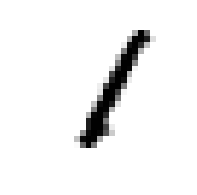

In [41]:
il[0].show()

# if you index into the il directly you get the actual image object, which has a show() method
# for some reason show is focusing on a zoomed in region, might be a temporary bug

<br>

## SPLIT TRAIN AND VALID:
#### Split the ItemList 

In [13]:
sd = il.split_by_folder(train='training', valid='testing')


# In this case, the 'testing' folder has labels, and is therefore a validation set.
# If you don't want a validation set for some reason, there is a no_split method,
# But you can't skip this step entirely 

In [15]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [16]:
(path/'training').ls()

# The folders have the correct labels

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4')]

<br>

## LABEL THE DATA:

In [17]:
ll = sd.label_from_folder()

In [18]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

6 torch.Size([1, 28, 28])


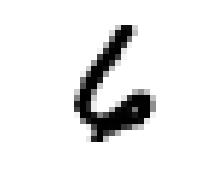

In [42]:
x,y = ll.train[12000]

# If you index into a LabelList, such as train, you'll get back an 
# independent and dependent variable (x, y)

x.show()
print(y,x.shape)

# x is image object
# y is category object

<br>

## TRANSFORM THE DATA:

In this case, we're not going to use the normal `get_transforms` function because we're doing digit recognition and you wouldn't want to flip it left or right, or rotate, because that would change the meaning of it. 

Also because these images are so small, doing zooms is going to make them so fuzzy as to be unreadable. So normally, for small images of digits like this, you just add a bit of random padding. So I'll use the random padding function which actually returns two transforms; the bit that does the padding and the bit that does the random crop. So you have to use star(*)to say put both these transforms in this list.

In [43]:
tfms_list = [*rand_pad(padding=3, size=28, mode='zeros')]

tfms = (tfms_list, [])
# The second empty array refers to no transforms on the validation set

In [44]:
ll = ll.transform(tfms)

## Create Databunch

In [45]:
bs = 128

In [46]:
data = ll.databunch(bs=bs).normalize()

# We will normalize. In this case, we're not using a pre-trained model, 
# so there's no reason to use ImageNet stats here. So if you call normalize like 
# this without passing in stats, it will grab a batch of data at random and use 
# that to decide what normalization stats to use. 
# That's a good idea if you're not using a pre-trained model.

6


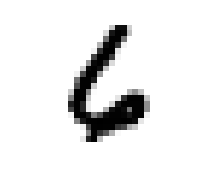

In [48]:
x,y = data.train_ds[12000]

# We can index into a DataSet to get x, y for each input

x.show()
print(y)

The training ds now has data augmentation from the transforms

`plot_multi` is a fast.ai function that will plot the result of calling some function for each of this row by column grid. 

So in this case, my `_plot` function is just:

"grab the first image from the training set and show it"

Each time you grab something from the training set, it's going to load it from disk and it's going to transform it on the fly, so potentially every one will look a little bit different each time. 

So you can see here, if we plot the result of that lots of times, we get 8's in slightly different positions because we did random padding.

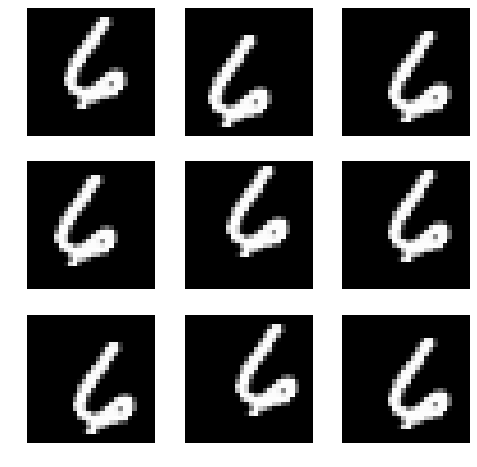

In [55]:
def _plot(i,j,ax): 
    data.train_ds[12000][0].show(ax, cmap='gray')

plot_multi(_plot, 3, 3, figsize=(8,8))

You can always grab a batch of data then from the data bunch

Databunch has data loaders, and data loaders are things you grab a batch at a time.<bR>
So you can then grab a X batch and a Y batch, look at their shape - batch size by channel by row by column:

In [53]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

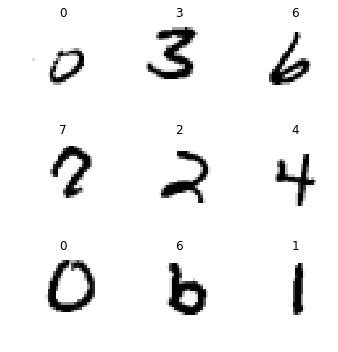

In [56]:
data.show_batch(rows=3, figsize=(5,5))

# Basic CNN with batchnorm

When creating architectures, it's convenient to define a function which does the things that we do repeatedly. <br>
I don't want to keep calling it with the same arguments because I'll forget or I make a mistake. <br>
In this case, all of my convolutions are going to be:

kernel size 3 <br>
stride 2 (each convolution will halve the grid size)<br>
padding 1

In [59]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

# ni = channels comming in
# nf = channels out / filters (anything you want)

In [58]:
# The commented numbers will show the new grid size after each conv
# number of input filters much equal output filters from previous conv

model = nn.Sequential(
    conv(1, 8), # 14, meaning an (8, 14, 14) tensor of activations
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1, meaning (10, 1, 1)
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid bc loss functions expect vector instead of rank 3 tensor
)

In [60]:
# Create the learner

learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [62]:
# print(learn.summary())
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [63]:
# Just to confirm that this is working okay, we can grab that mini batch xb that we created earlier,
# pop it onto the GPU, and call the model directly. 
# Any PyTorch module can be called like a function
# This gives us back, as we hoped, a 128 by 10 result.
 
xb = xb.cuda()

In [64]:
model(xb).shape

torch.Size([128, 10])

# Train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


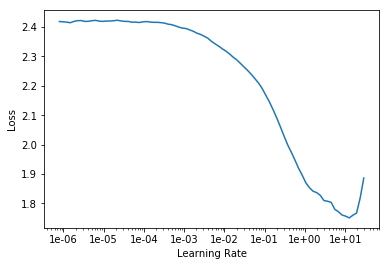

In [65]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(5, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.226855,0.348125,0.903200,00:06
1,0.160685,0.182733,0.942500,00:06
2,0.126084,0.079366,0.974900,00:06
3,0.076451,0.046041,0.984900,00:06
4,0.060776,0.032192,0.989800,00:06


We already have a 98.9% accurate model without using a pretrained model, using a simple architecture

# Refactoring

Rather than saying conv, batch norm, ReLU all the time, fast.ai already has something called `conv_layer` which lets you create conv, batch norm, ReLU combinations. <bR>
It has various other options to do other tweaks to it, but we'll use the basic version.<br>
https://docs.fast.ai/layers.html#conv_layer

In [67]:
# Make a new conv function to create our layers

def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [68]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [69]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [70]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.244623,0.160335,0.953900,00:06
1,0.203864,0.164429,0.949200,00:06
2,0.167430,0.096134,0.967600,00:06
3,0.137916,0.164528,0.947600,00:06
4,0.125992,0.143595,0.951100,00:06
5,0.111240,0.063199,0.982000,00:06
6,0.088612,0.058462,0.981900,00:06
7,0.067819,0.041084,0.987500,00:06
8,0.055150,0.028357,0.991000,00:06
9,0.045994,0.026667,0.991700,00:06


And there you have it. Simple code, simple architecture, greate results

# Resnet-ish

#### Adding identity (skip) connections

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson7/8.png'/>

Every two convolutions, I'm going to add together the input to those two convolutions with the result of those two convolutions." <br>

In other words, instead of saying:

[Output=Conv2(Conv1(x))]

Instead, he's saying:

[Output=x+Conv2(Conv1(x))] 

In [75]:
# This is how we would create a ResBlock with the skip connection:
# Create a nn.Module, we create two conv layers (remember, a conv_layer is Conv2d, ReLU, batch norm)
# in forward we do conv1(x), conv2 of that and then add x

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [77]:
# Conveniently, there's already a res_block function in fastai
# Just pass in the number of filters

help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [78]:
# This new architecture has 3x as many layers as the previous one
# Should be able to do more comppute without being harder to optimize

model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

#### Refactor one more time

Create a function that adds the conv and the res_block

It's a great idea, almost imperative, that you refactor your novel arcitectures so that you make less mistakes

In [79]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [80]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [81]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


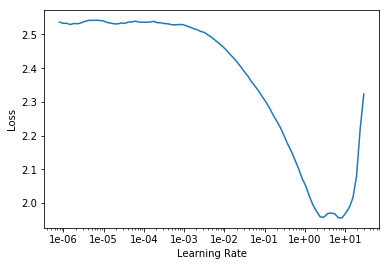

In [82]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.233583,0.210866,0.941200,00:07
1,0.138044,0.142934,0.956600,00:08
2,0.110417,0.208499,0.932400,00:08
3,0.088888,0.088511,0.973200,00:08
4,0.077156,0.085990,0.973600,00:08
5,0.066689,0.057787,0.982100,00:08
6,0.049527,0.032568,0.990100,00:08
7,0.042875,0.028419,0.990700,00:08
8,0.038976,0.028643,0.991200,00:08
9,0.027714,0.018891,0.993900,00:08


This puts us around state of the art for 3 years ago with very minimal architecture and training.

At this point, it's not terribly groundbreaking, it's just showing how useful a resnet architecture is.<br>
fast.ai uses this architecture in most/all ImageNet stuff

In [85]:
# print(learn.summary())

If you look at the definition of `res_block` in the fast.ai code (below), you'll see it looks a little bit different to this, and that's because I've created something called a `MergeLayer`. A `MergeLayer` is something which in the forward (just skip dense for a moment), the forward says `x+x.orig`. So you can see there's something ResNet-ish going on here. What is `x.orig`? Well, if you create a special kind of sequential model called a `SequentialEx`  so this is like fast.ai's sequential extended. It's just like a normal sequential model, but we store the input in `x.orig`. So this `SequentialEx`, `conv_layer`, `conv_layer`, `MergeLayer`, will do exactly the same as `ResBlock`. So you can create your own variations of ResNet blocks very easily with this `SequentialEx` and `MergeLayer`.

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson7/12.png'/>


There's something else here which is when you create your MergeLayer, you can optionally set `dense=True`, and what happens if you do? Well, if you do, it doesn't go `x+x.orig`, it goes `cat([x,x.orig])`. In other words, rather than putting a plus in this connection, it does a concatenate. That's pretty interesting because what happens is that you have your input coming in to your Res block, and once you use concatenate instead of plus, it's not called a Res block anymore, it's called a dense block. And it's not called a ResNet anymore, it's called a DenseNet.

The DenseNet was invented about a year after the ResNet, and if you read the DenseNet paper, it can sound incredibly complex and different, but actually it's literally identical but plus here is placed with cat. So you have your input coming into your dense block, and you've got a few convolutions in here, and then you've got some output coming out, and then you've got your identity connection, and remember it doesn't plus, it concats so the channel axis gets a little bit bigger. Then we do another dense block, and at the end of that, we have the result of the convolution as per usual, but this time the identity block is that big.

<img src='https://raw.githubusercontent.com/hiromis/notes/master/lesson7/13.png'/>

So you can see that what happens is that with dense blocks it's getting bigger and bigger and bigger, and kind of interestingly the exact input is still here. So actually, no matter how deep you get the original input pixels are still there, and the original layer 1 features are still there, and the original layer 2 features are still there. So as you can imagine, DenseNets are very memory intensive. There are ways to manage this. From time to time, you can have a regular convolution and it squishes your channels back down, but they are memory intensive. But, they have very few parameters. 

So for dealing with small datasets, you should definitely experiment with dense blocks and DenseNets. They tend to work really well on small datasets.

Also, because it's possible to keep those original input pixels all the way down the path, they work really well for segmentation. Because for segmentation, you want to be able to reconstruct the original resolution of your picture, so having all of those original pixels still there is a super helpful.

## fin